In [2]:
import supereeg as se
import pandas as pd
import numpy as np
import os
import itertools
from scipy import stats
import nibabel as nib
import hypertools as hyp
import plot as plot
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from nilearn import plotting as ni_plt
import matplotlib.colors as colors
import seaborn as sns

In [3]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i) 
    return(colors_rgba[:N, :3])

In [4]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [5]:
r=20

In [6]:
fig_dir = '../../paper/figs/source/best_locs'
nii_bo_dir = '../../data/niis'
freq_fig_dir = '../../paper/figs/source/freq'


In [7]:
ram_data_dir = '../../data/ram'
pyfr_data_dir = '../../data/pyfr'

In [8]:
ram_freq_dir = os.path.join(ram_data_dir, 'freq')
pyfr_freq_dir = os.path.join(pyfr_data_dir, 'freq')

In [9]:
RAM_df = pd.read_csv(os.path.join(ram_data_dir, 'ram.csv'), index_col=0)
pyFR_df = pd.read_csv(os.path.join(pyfr_data_dir, 'pyfr.csv'), index_col=0)

In [10]:

freqs = ['raw', 'delta', 'theta', 'alpha', 'beta', 'lgamma', 'hgamma', 'broadband']
latex_freqs = ['all', "$\delta$", r'$\theta$', r'$\alpha$', r'$\beta$', "$\gamma_L$", "$\gamma_H$", 'broadband']

In [11]:
#freqs = ['broadband']

In [12]:

most_infos = []

for e, freq in enumerate(freqs):
    ram_freq_df = pd.DataFrame()
    pyfr_freq_df = pd.DataFrame()

    freq_dfs = [ram_freq_df, pyfr_freq_df]

    ram_info = np.array([])
    pyfr_info = np.array([])
    most_infos_freq = [ram_info, pyfr_info]
    
    for d, ds in enumerate(['ram', 'pyfr']):
        
        ds_dir = ds + '_freq_dir'
        temp_pd = pd.read_csv(os.path.join(eval(ds_dir), freq + '.csv'), index_col=0)
        temp_pd.name = ds
        temp_pd['across'] = plot.r2z(temp_pd['across'])
        temp_pd['within'] = plot.r2z(temp_pd['within'])
        temp_pd_mean = temp_pd.groupby('Subject')['across','within'].mean()
        
        corr_by_subject = np.array([])
        
        R_locs = []
        subj_by_subject = np.array([])
        for i, s in enumerate(temp_pd_mean.index):


            sub_locs = plot.compile_df_locs(temp_pd['R'][temp_pd['Subject'] == s])

            if R_locs == []:
                R_locs = sub_locs 
            else:

                R_locs = np.vstack((R_locs, sub_locs))

            sub_corr = np.atleast_2d(temp_pd_mean['across'][i])

            corr_by_subject = np.append(corr_by_subject, np.array([temp_pd_mean['across'][i]]* np.shape(sub_locs)[0]))

            subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(sub_locs)[0]))



        freq_dfs[d]['Correlation'] = plot.z2r(corr_by_subject)
        freq_dfs[d]['Subject'] = subj_by_subject
        freq_dfs[d]['R'] = None
        
        R_locs_str = []
        for i in range(freq_dfs[d].shape[0]):
            R = str(R_locs[i])
            if R_locs_str == []:
                R_locs_str = R
            else:

                R_locs_str = np.vstack((R_locs_str, R))

        freq_dfs[d]['R'] = R_locs_str

    
        most_infos_freq[d] = plot.most_informative_locs(freq_dfs[d], vox_size=4, width=r)
        
    most_infos.append(np.array(most_infos_freq))

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:32: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [13]:
## for fsl view overlay
sub_nii = se.load('std', vox_size=4)
sub_locs = sub_nii.get_locs().values
sub_nii.save(os.path.join(fig_dir, '4mm_brain.nii'))

In [14]:
display.add_contours(mask, filled=True, alpha=0.7,
                     levels=[0.5], colors='b')

ni_plt.show()

AttributeError: 'function' object has no attribute 'add_contours'

In [ ]:
sub_nii.dataobj[sub_nii.dataobj!=0]=0
h = ni_plt.plot_glass_brain(sub_nii, colorbar=True, threshold=0, vmax=1, vmin=-1, display_mode='lyrz')
h.add_contours(mask, filled=True, alpha=0.7, levels=[.5], colors=[rgba[0]], linewidths=2)
ni_plt.show()

In [15]:
freqnames = ['all', "$\delta$", r'$\theta$', r'$\alpha$', r'$\beta$', "$\gamma_L$", "$\gamma_H$", 'broadband']
gray = matplotlib.colors.to_rgb('gray')
light_gray = matplotlib.colors.to_rgb('lightgray')
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(freqnames[1:]))
rgba = cmap_discretize(matplotlib.cm.Spectral, len(freqnames[1:]))
rgba_null = cmap_discretize(cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.Spectral),len(freqnames[1:])) 
rgba = sns.color_palette(np.vstack((gray, np.array(rgba))))
rgba_null = sns.color_palette(np.vstack((light_gray, np.array(rgba_null))))

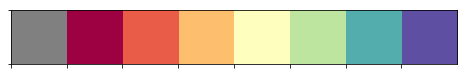

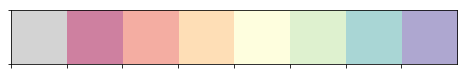

In [16]:
sns.palplot(rgba)
sns.palplot(rgba_null)

KeyboardInterrupt: 

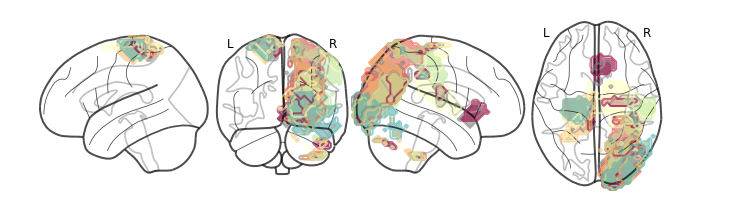

In [17]:
sub_nii.dataobj[sub_nii.dataobj!=0]=0
g = ni_plt.plot_glass_brain(sub_nii, colorbar=True, threshold=0, vmax=1, vmin=-1, display_mode='lyrz')

for e, freq in enumerate(freqs):
    
    best_locs_mask = pd.DataFrame()
    best_locs_mask['RAM'] = most_infos[e][0]
    best_locs_mask['PyFR'] = most_infos[e][1]
    
    pyfr_best = best_locs_mask['PyFR']> np.percentile(best_locs_mask['PyFR'].values, 90)

    ram_best = best_locs_mask['RAM']> np.percentile(best_locs_mask['RAM'].values, 90)
    
    intersect = pyfr_best.astype('int64') + ram_best.astype('int64')

    masked_best_locs = intersect>1
    bo_nii_best = se.Brain(data=np.atleast_2d(masked_best_locs), locs=sub_locs)
    #bo_nii_best.save(os.path.join(nii_bo_dir, freq + '_best'))
    nii_bo_best = se.helpers._brain_to_nifti(bo_nii_best, sub_nii)

    mask = nib.Nifti1Image(header=nii_bo_best.header, dataobj=np.squeeze(nii_bo_best.get_data()), affine=nii_bo_best.affine)
    
    #nii_bo_best.save(os.path.join(fig_dir, freq + '_90th.nii'))
    
    mask_bo = se.Brain(data=np.atleast_2d(masked_best_locs[masked_best_locs]+e), locs=sub_locs[masked_best_locs])
    mask_bo.save(os.path.join(nii_bo_dir, freq + '_best'))
    
    g.add_contours(mask, filled=True, alpha=0.6, levels=[.5], colors=[rgba[e]], linewidths=2)


In [18]:
ni_plt.show()

pyfr raw


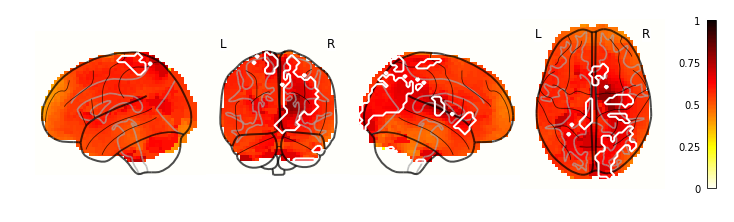

ram raw


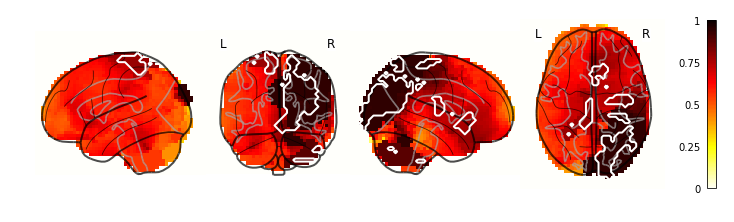

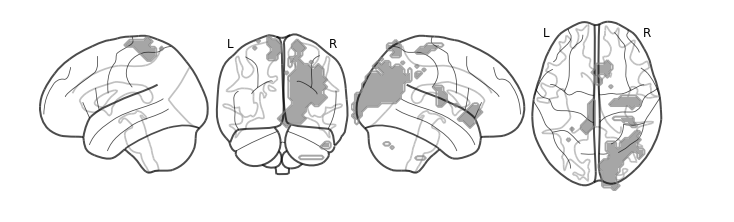

pyfr delta


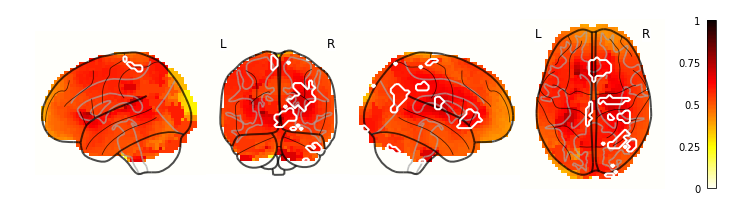

ram delta


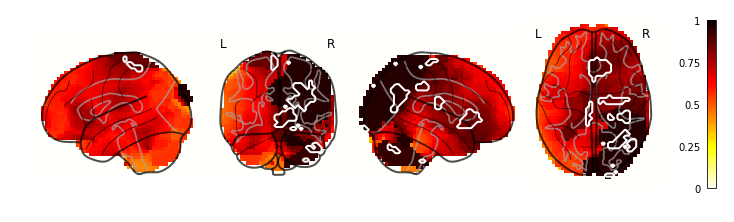

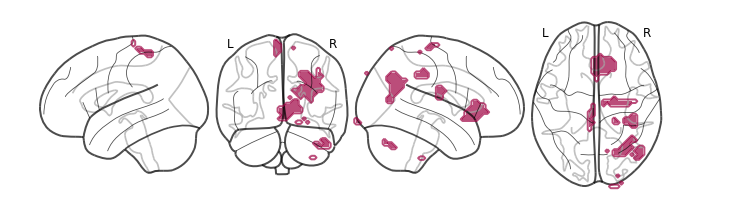

pyfr theta


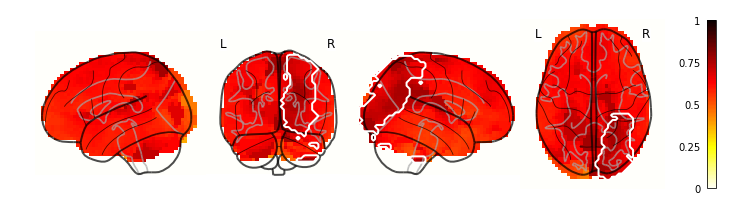

ram theta


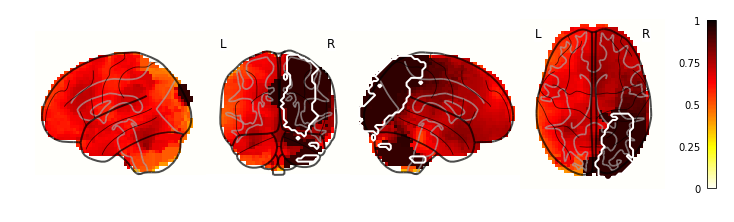

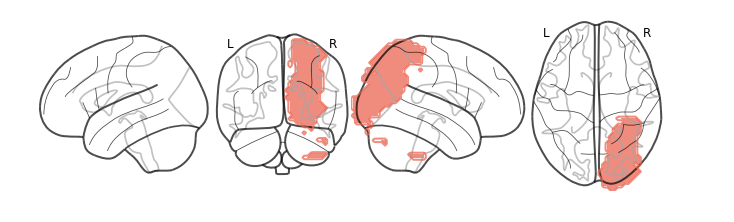

pyfr alpha


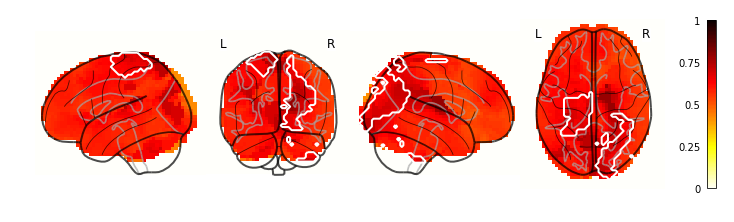

ram alpha


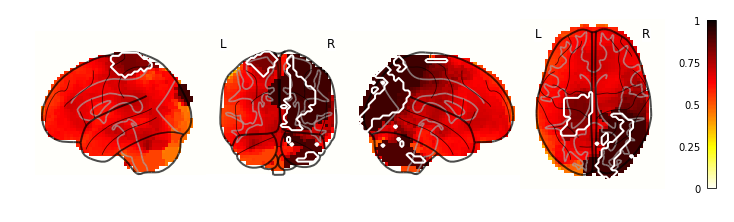

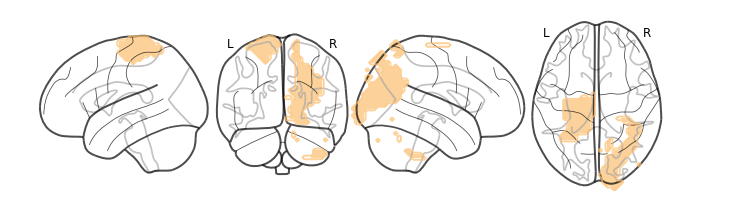

pyfr beta


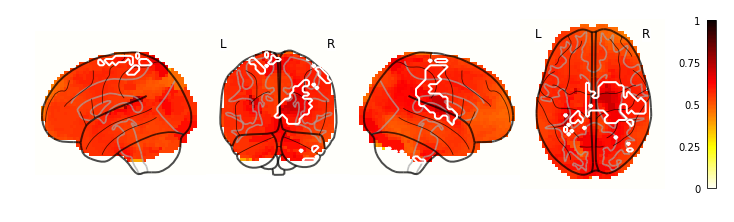

ram beta


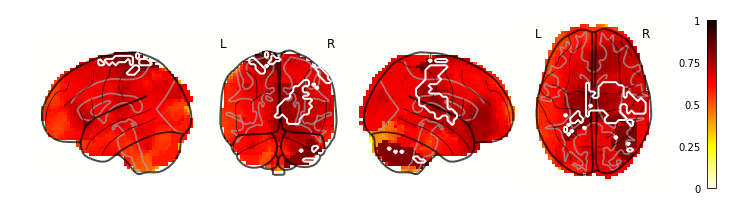

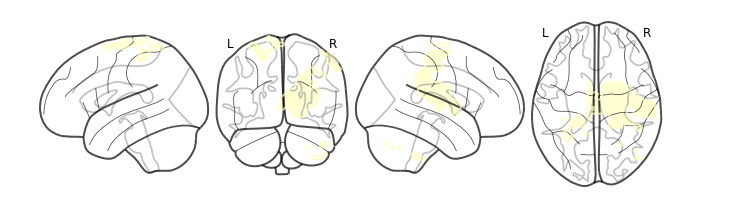

pyfr lgamma


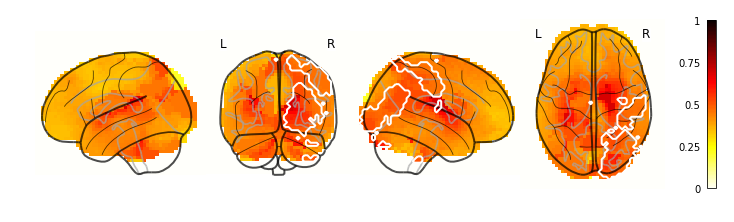

ram lgamma


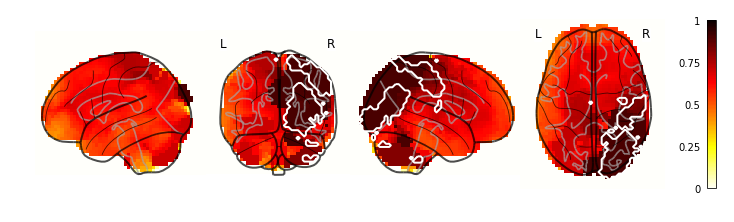

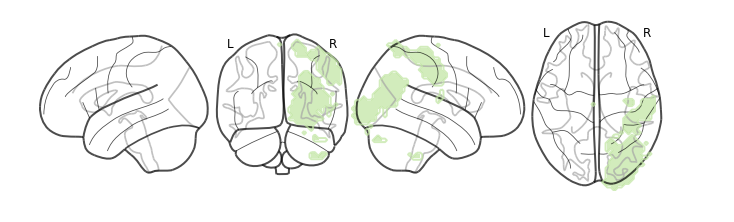

pyfr hgamma


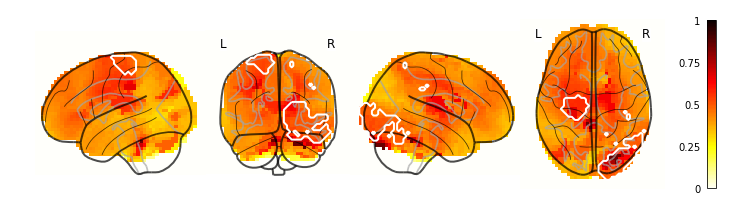

ram hgamma


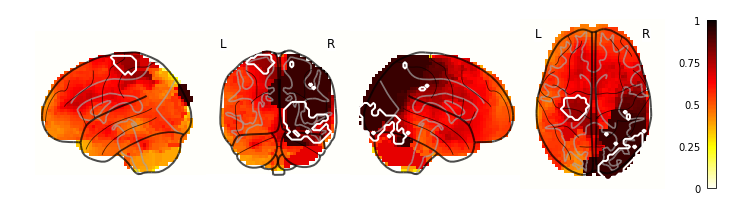

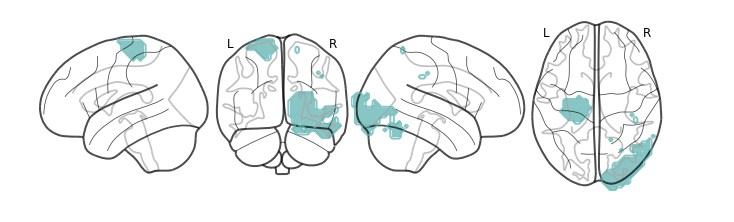

pyfr broadband


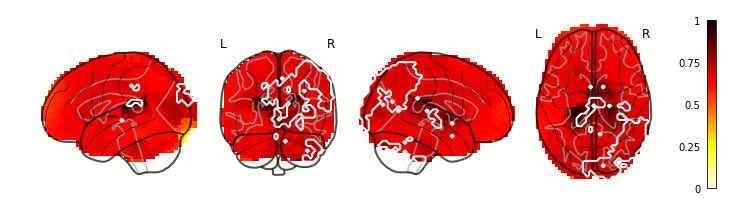

ram broadband


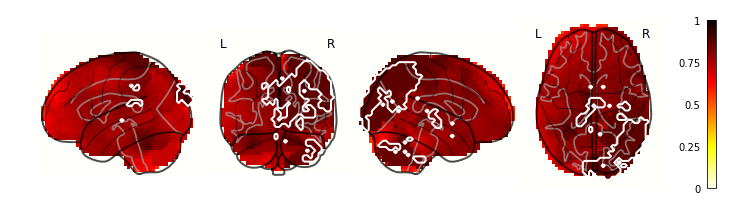

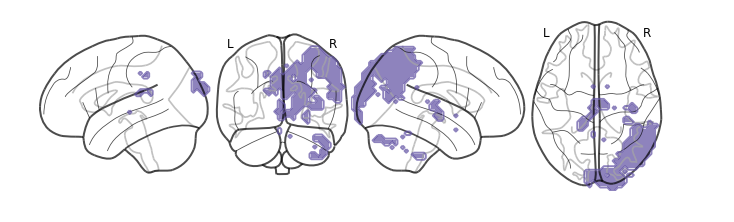

In [24]:
for e, freq in enumerate(freqs):
    
    best_locs_mask = pd.DataFrame()
    best_locs_mask['RAM'] = most_infos[e][0]
    best_locs_mask['PyFR'] = most_infos[e][1]
    
    pyfr_best = best_locs_mask['PyFR']> np.percentile(best_locs_mask['PyFR'].values, 90)

    ram_best = best_locs_mask['RAM']> np.percentile(best_locs_mask['RAM'].values, 90)
    
    intersect = pyfr_best.astype('int64') + ram_best.astype('int64')

    masked_best_locs = intersect>1
    bo_nii_best = se.Brain(data=np.atleast_2d(masked_best_locs), locs=sub_locs)
    #bo_nii_best.save(os.path.join(nii_bo_dir, freq + '_best'))
    nii_bo_best = se.helpers._brain_to_nifti(bo_nii_best, sub_nii)
    
    mask = nib.Nifti1Image(header=nii_bo_best.header, dataobj=np.squeeze(nii_bo_best.get_data()), affine=nii_bo_best.affine)
    
    nib.save(mask, os.path.join(nii_bo_dir, freq + '_best.nii'))
    
    mask_bo = se.Brain(data=np.atleast_2d(masked_best_locs[masked_best_locs]+(e-1)), locs=sub_locs[masked_best_locs])
    mask_bo.save(os.path.join(nii_bo_dir, freq + '_best'))
    
    print('pyfr ' + freq)
    bo_nii = se.Brain(data=np.atleast_2d(best_locs_mask['PyFR'].values), locs=sub_locs)
    nii_bo = se.helpers._brain_to_nifti(bo_nii, sub_nii)
    nii_bo.save(os.path.join(nii_bo_dir, freq + '_pyfr_90th.nii'))
    h = ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')
    h.add_contours(mask, levels=[.5], colors='w', linewidths=2)
    ni_plt.show()
    
    print('ram ' + freq)
    bo_nii = se.Brain(data=np.atleast_2d(best_locs_mask['RAM'].values), locs=sub_locs)
    nii_bo = se.helpers._brain_to_nifti(bo_nii, sub_nii)
    nii_bo.save(os.path.join(nii_bo_dir, freq + '_ram_90th.nii'))
    h = ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')
    h.add_contours(mask, levels=[.5], colors='w', linewidths=2)
    ni_plt.show()
    
    sub_nii.dataobj[sub_nii.dataobj!=0]=0
    g = ni_plt.plot_glass_brain(sub_nii, colorbar=True, threshold=0, vmax=1, vmin=-1, display_mode='lyrz')
    g.add_contours(mask, filled=True, alpha=0.7, levels=[.5], colors=[rgba[e]], linewidths=2)
    ni_plt.show()

raw


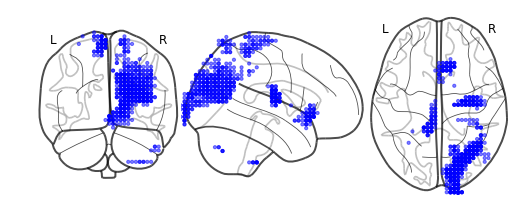

delta


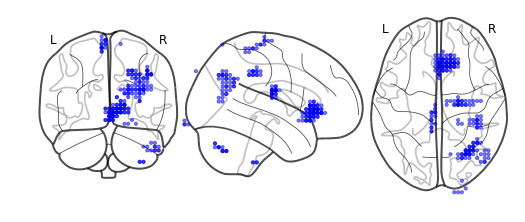

theta


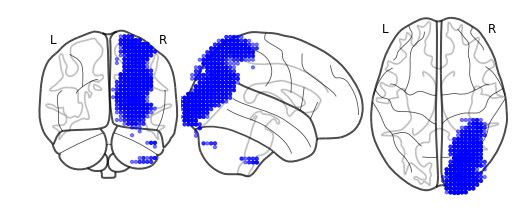

alpha


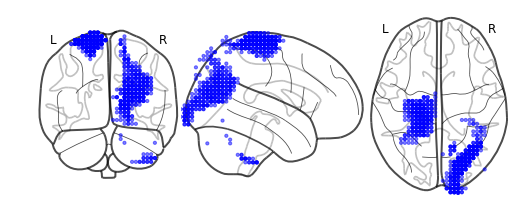

beta


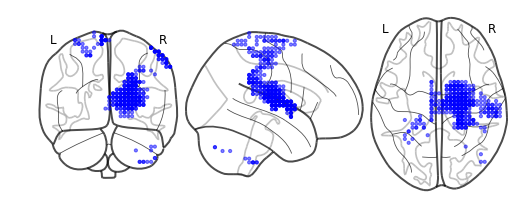

lgamma


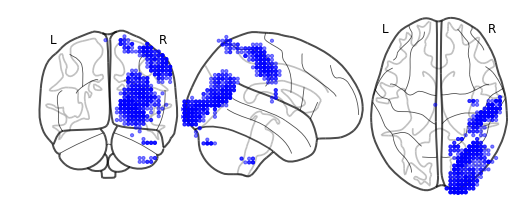

hgamma


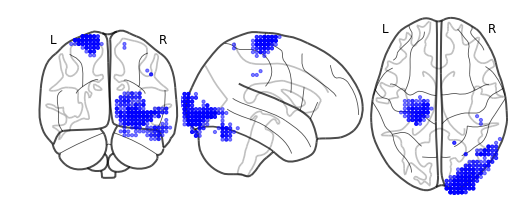

broadband


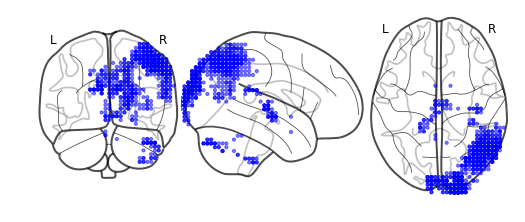

In [69]:
for f in freqs:
    bo = se.load(os.path.join(nii_bo_dir, f+ '_best.bo'))
    print(f)
    bo.plot_locs()

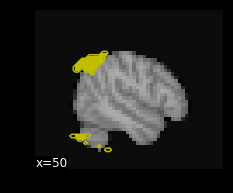

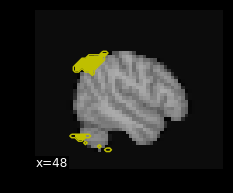

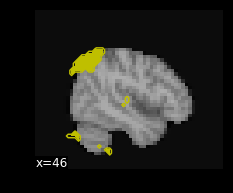

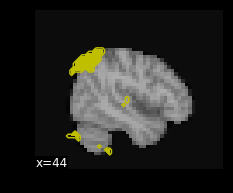

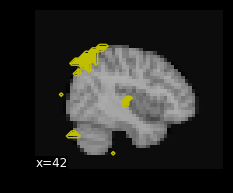

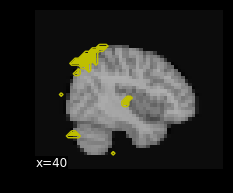

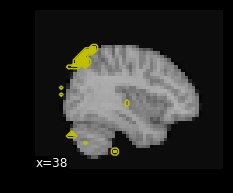

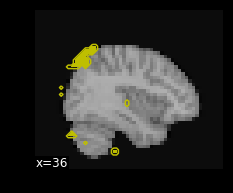

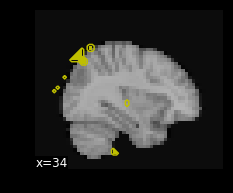

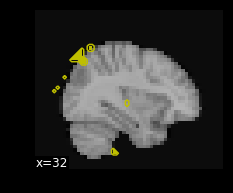

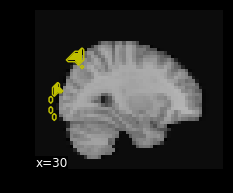

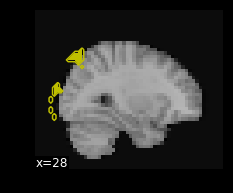

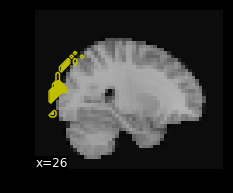

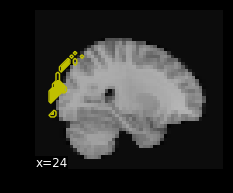

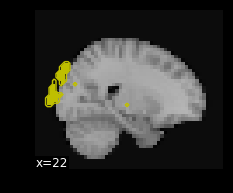

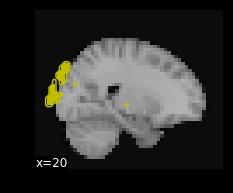

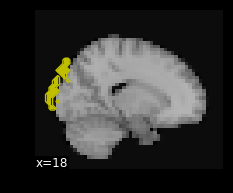

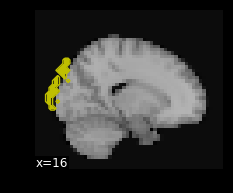

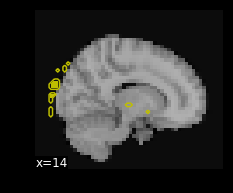

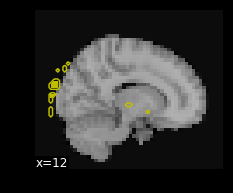

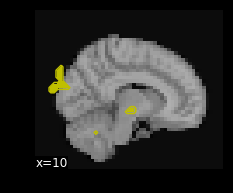

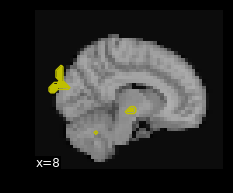

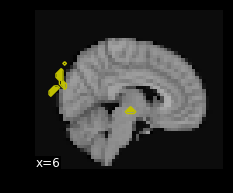

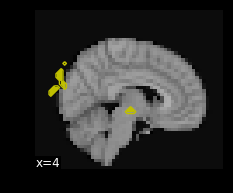

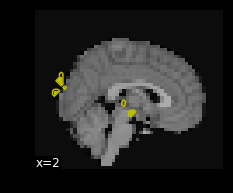

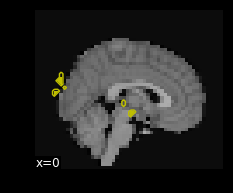

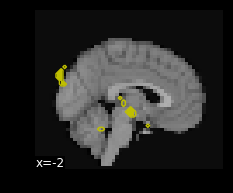

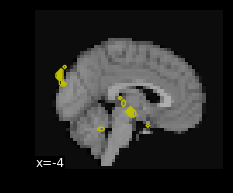

In [17]:
cut_it = list(range(-4, 52, 2))[::-1]

for i in cut_it:

    display = ni_plt.plot_anat(sub_nii, display_mode='x', cut_coords=[i])
    display.add_contours(mask, levels=[.5], filled=True, colors='y')